In [ ]:
#https://colab.research.google.com/drive/1pmZaLCabA-Gkb5-QvesoqRUBhzSa-frv?usp=sharing

import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
!pip install matplotlib==3.1.3
!pip install cmdstanpy>=1.0.1
!pip install pystan~=2.14
!pip install fbprophet
from fbprophet import Prophet
import matplotlib.pyplot as plot

In [59]:
dataset = pd.read_csv('all_breakdown.csv')

In [60]:
#2.a Crie uma nova coluna "SOLAR TOTAL" resultante da soma das colunas "SOLAR PV", "SOLAR THERMAL" e "SOLAR";
dataset["SOLAR TOTAL"] = dataset[ ["SOLAR PV","SOLAR THERMAL", "SOLAR"] ].sum(axis = 1)

dataset["SOLAR TOTAL"]

0        0.0
1        0.0
2        0.0
3        0.0
4        0.0
        ... 
67579    0.0
67580    0.0
67581    0.0
67582    0.0
67583    0.0
Name: SOLAR TOTAL, Length: 67584, dtype: float64

In [61]:
#2.b Converta a coluna TIMESTAMP para datetime;

dataset['TIMESTAMP'] = pd.to_datetime(dataset['TIMESTAMP'], errors='coerce')

dataset['TIMESTAMP']

0       2011-07-21 00:00:00
1       2011-07-21 01:00:00
2       2011-07-21 02:00:00
3       2011-07-21 03:00:00
4       2011-07-21 04:00:00
                ...        
67579   2013-01-28 19:00:00
67580   2013-01-28 20:00:00
67581   2013-01-28 21:00:00
67582   2013-01-28 22:00:00
67583   2013-01-28 23:00:00
Name: TIMESTAMP, Length: 67584, dtype: datetime64[ns]

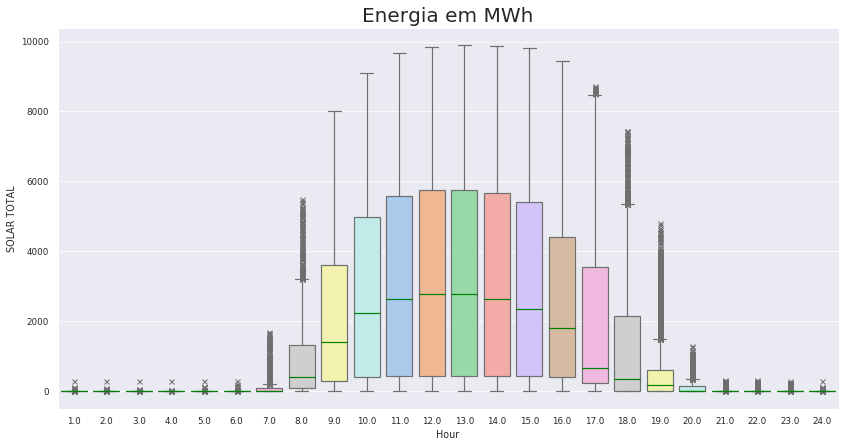

In [23]:
#Crie um plot onde o eixo X represente as 24 horas do dia e o eixo Y represente a quantidade de energia (em MWh). Nesse plot, você irá criar um boxplot mostrando a distribuição da energia gerada (variável SOLAR TOTAL) por hora (Dica 1: Crie uma coluna auxiliar. Dica 2: use seaborn);
fig, ax = plot.subplots(figsize = (14,7)) 
ax.set_title( "Energia em MWh" , size = 20 )
sns.set_style("darkgrid")
sns.set_context("paper")
sns.boxplot(data=dataset, x="Hour", y="SOLAR TOTAL", palette="pastel", flierprops={"marker": "x" }, medianprops={"color": "green"})

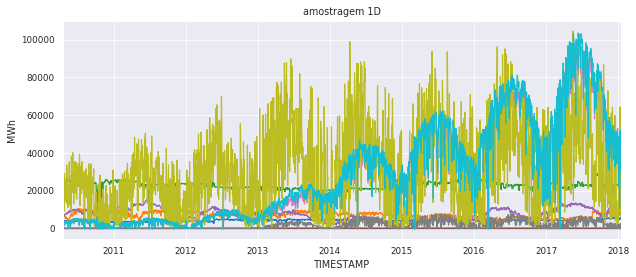

In [50]:
#2.D Reamostre a série SOLAR TOTAL para a frequência 1D e faça um gráfico;
dataset.set_index('TIMESTAMP',inplace=True)
fig, ax = plot.subplots(1, 1, figsize=(10, 4))

ax.set_title("amostragem 1D")

ax.set_xlabel('Data')
ax.set_ylabel('MWh')

dataset.resample('1D').sum().plot(ax=ax,legend=False)

#reset
dataset = pd.read_csv('all_breakdown.csv')
dataset["SOLAR TOTAL"] = dataset[ ["SOLAR PV","SOLAR THERMAL", "SOLAR"] ].sum(axis = 1)
dataset['TIMESTAMP'] = pd.to_datetime(dataset['TIMESTAMP'], errors='coerce')

In [62]:
dataset = dataset[["TIMESTAMP","SOLAR TOTAL"]].sort_values("TIMESTAMP", ascending=True )
dataset['TIMESTAMP'] = pd.to_datetime(dataset.TIMESTAMP)
dataset.set_index('TIMESTAMP',inplace=True)
dataset = dataset.resample('1D').sum()
dataset.reset_index(inplace=True)
dataset['TIMESTAMP'] = pd.to_datetime(dataset.TIMESTAMP)

treino = (dataset['TIMESTAMP'] < '2017-01-01')
teste = (dataset['TIMESTAMP'] >= '2017-01-01')
datatreino = dataset[treino]
datatest = dataset[teste]

dataset.set_index('TIMESTAMP', inplace=True)
datatreino.set_index('TIMESTAMP', inplace=True)
datatest.set_index('TIMESTAMP', inplace=True)

In [71]:
size_of_train = int(np.ceil(datatreino.shape[0]) * (.85) )
train = datatreino[:size_of_train]
valid = datatreino[:size_of_train]
train_prophet = train.reset_index().rename(columns={"TIMESTAMP":'ds',"SOLAR TOTAL":'y'})
periods = datatreino.shape[0] - valid.shape[0]
valid_prophet = valid.reset_index().rename(columns={"TIMESTAMP":'ds',"SOLAR TOTAL":'y'})
model = Prophet()
model.fit(train_prophet)
future = model.make_future_dataframe(periods=periods, freq="D", include_history=True)
forecast = model.predict(future)


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


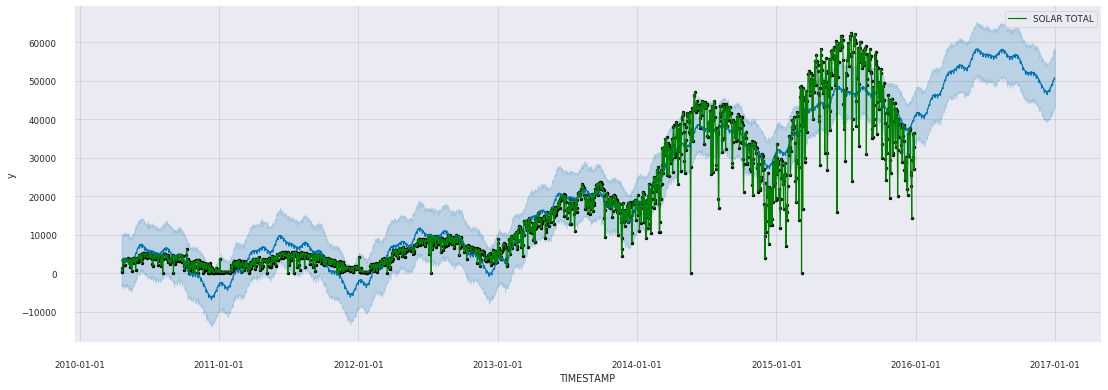

In [72]:
model.plot(forecast)
prophetPlot = plot.gca()
valid.plot(c="g", ax=prophetPlot, figsize=(16,6) )
prophetPlot.yaxis.grid(True)
sns.despine(top=6,right=6,trim=6,offset=10)
plot.show()

In [86]:
#2.f Calcule o R2 Score e Mean Average Error entre a previsão e o conjunto de testes.

y_hat_val = forecast.yhat[:size_of_train]
r2Score = r2_score(valid.values, y_hat_val)
MeanAverageError = mean_squared_error(valid.values, y_hat_val, squared=False)


print(f'r2 Score: {r2Score}\nMean Average Error: {MeanAverageError} ')


r2 Score: 0.9026191304923514
Mean Average Error: 5265.176527621696 
